# Motivation

Training a state of the art machine learning model usually takes:
- a few days,
- thousands of dollars of hardware, and
- a massive amount of data.

Since most hackathon teams don't have any of those, transfer learning is often used instead. This takes much less time, compute, and data.

Transfer learning is explained [here](https://cs231n.github.io/transfer-learning/). Basically, we will use a pretrained model as a feature extractor and train only its last layer to classify new data.

# Finding Existing Data and Models

A great source of datasets: [kaggle.com/datasets](kaggle.com/datasets)

A great source of models: [pytorch.org/hub](pytorch.org/hub)

For this example, we'll use the [LEGO Minifigures Dataset](https://www.kaggle.com/ihelon/lego-minifigures-classification) and [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/).

### Downloading the data

If you're using google colab, ownload the dataset and upload it to your google drive, then mount your google drive. It needs to be mounted before this colab notebook can read data there.

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


See if we can find the data:

(Prepending `!` runs the command in a shell on google colab)

In [ ]:
!ls /content/drive/My\ Drive/datasets

lego


In [ ]:
!ls /content/drive/My\ Drive/datasets/lego

harry-potter  jurassic-world  marvel	    star-wars  test.csv
index.csv     LICENSE	      metadata.csv  test


In this example the dataset is in the folder `My Drive/datasets/lego`. Store the path to the data in `root_dir`:

In [ ]:
root_dir = '/content/drive/My Drive/datasets/lego/'

# Examining the Data

![lego minifigures](https://camo.githubusercontent.com/d3543f3d934ff5480920c22bead00ac2901a77d87986d1afd8475cdc42a766a9/68747470733a2f2f692e696d6775722e636f6d2f346350516c454e2e6a7067)

*Image Source: https://github.com/yisaienkov/tinysets*

Look at the files.

In [ ]:
# 'index.csv' is a manifest of the training data

import pandas as pd
import os

data_df = pd.read_csv(os.path.join(root_dir, 'index.csv'))
data_df.head()

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1


In [ ]:
# 'test.csv' is a manifest of the testing data
data_df_test = pd.read_csv(os.path.join(root_dir, 'test.csv'))
data_df_test.head()

,path,class_id
0,test/001.jpg,32
1,test/002.jpg,32
2,test/003.jpg,32
3,test/004.jpg,32
4,test/005.jpg,1


In [ ]:
# 'metadata.csv' is a mapping of class_ids to figure names
figure_names = pd.read_csv(os.path.join(root_dir, 'metadata.csv'))
figure_names.head()

,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA


How many different classes are there?

In [ ]:
print("Number of classes: {}".format(len(figure_names)))

Number of classes: 32


How much training data?

Total number of training images: 316


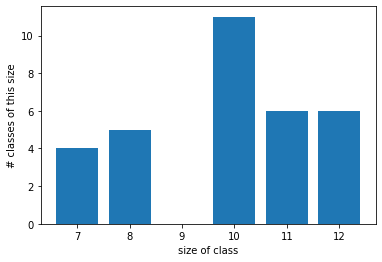

In [ ]:
print("Total number of training images: {}".format(len(data_df)))

# how many images in each class?

import matplotlib.pyplot as plt

class_sizes = data_df.class_id.value_counts().value_counts()
plt.bar(class_sizes.index, class_sizes.values)
plt.xlabel('size of class')
plt.ylabel('# classes of this size')
plt.show()

How much testing data?

Total number of test images: 62


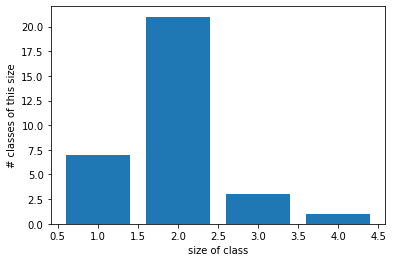

In [ ]:
print("Total number of test images: {}".format(len(data_df_test)))

# how many images in each class?

class_sizes = data_df_test.class_id.value_counts().value_counts()
plt.bar(class_sizes.index, class_sizes.values)
plt.xlabel('size of class')
plt.ylabel('# classes of this size')
plt.show()

Look at an example image:

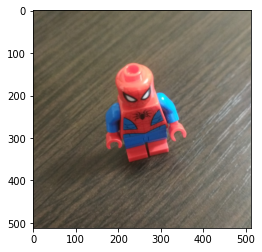

In [ ]:
from PIL import Image

sample_img = Image.open(os.path.join(root_dir, data_df.loc[0, 'path']))
plt.imshow(sample_img)

Dimensions of the image?

In [ ]:
sample_img.size

(512, 512)

Create a function to translate `class_id`s to figure names:

In [ ]:
def get_figure_name(class_id):
  return figure_names.loc[figure_names.class_id == class_id, 'minifigure_name'].item()

In [ ]:
get_figure_name(1)

'SPIDER-MAN'

Prepare the data to use in training:

In [ ]:
# make a `Dataset` out of this data
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

from torch.utils.data import Dataset

class LegoDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.data = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
                            
    if self.transform:
      imgs = self.transform(Image.open(img_path))
    else:
      imgs = np.array(Image.open(img_path))

    class_ids = self.data.iloc[idx, 1] - 1  # labels are not zero indexed

    return imgs, class_ids

Create datasets and dataloaders for the training and testing data

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# ResNet requires specifically formatted input data
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

# create the datasets
datasets = {
  'train': LegoDataset(
    csv_file=os.path.join(root_dir, 'index.csv'), 
    root_dir=root_dir,
    transform=data_transforms['train']
  ),
  'test': LegoDataset(
    csv_file=os.path.join(root_dir, 'test.csv'), 
    root_dir=root_dir,
    transform=data_transforms['test']
  )
}

# create the dataloaders
dataloaders = {
  mode: DataLoader(datasets[mode], batch_size=4, shuffle=True, num_workers=4)
  for mode in ['train', 'test']
}

# Preparing the Model

We can download pretrained ResNet from PyTorch Hub:

In [ ]:
import torch

model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The output layer of the model (`fc`) is a `Linear` layer with 512 inputs and 1000 outputs (it was trained on ImageNet, which has 1000 classes). We want to replace it with a layer with 32 outputs. Additionally, we want to freeze all the layers except the last one.

In [ ]:
# freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# replace the last layer
import torch.nn as nn

model.fc = nn.Linear(512, 32)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The output layer now has 32 outputs, as desired.

We also want to move the model to the GPU so it trains faster. (Don't forget to enable GPU runtime!)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

device: cuda:0


# Training

Define some parameters for training:

In [ ]:
LEARNING_RATE = 0.001  # how much the model's weights are changed in each training iteration
EPOCHS = 40            # the number of times to train on the full dataset

Define a loss function. (This calculates how correct or incorrect the model's predictions were.)

In [ ]:
criterion = nn.CrossEntropyLoss()

Define an optimization algorithm. (This updates the weights in the model to decrease the loss from the loss function.)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Train the model.

In [ ]:
import time

start = time.time()

model.train()  # set the model to training mode (don't ignore batchnorm layers)
torch.set_grad_enabled(True)

losses = []  # keep track of loss to see improvement

for epoch in range(EPOCHS):

  running_loss = 0.0

  for inputs, labels in dataloaders['train']:
    # since the model is on the GPU, the training data moves there as well
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()  # zero out previous weight gradients
    outputs = model(inputs)  # predict classes for the training data
    loss = criterion(outputs, labels)  # check how incorrect the model is
    loss.backward()  # calculate the gradients
    optimizer.step()  # update the weights

    running_loss += loss.item() * inputs.size(0)

  losses.append(running_loss)
  running_loss = 0.0


duration = time.time() - start
print('Time spent training: {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

Time spent training: 1m 52s


Check if the loss decreased.

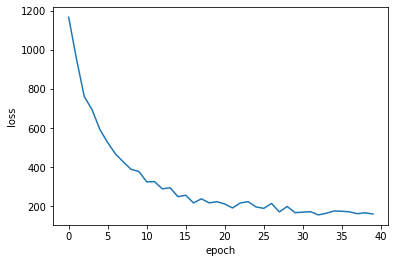

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Did it work?

Choose a testing image.

True name: AUNT MAY


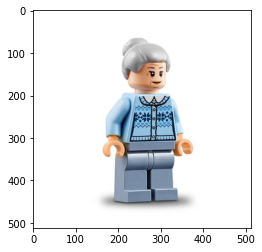

In [ ]:
sample_index = 9  # try a few!

sample_test = data_df_test.loc[sample_index]
sample_test_img = Image.open(os.path.join(root_dir, sample_test.path))
plt.imshow(sample_test_img)
print("True name: {}".format(get_figure_name(sample_test.class_id)))

Predict the figure's name using the model.

In [ ]:
img1, label1 = datasets['test'][sample_index]

model.eval()
with torch.no_grad():
  output = model(img1.unsqueeze(0).to(device))

predicted_class = torch.argmax(output[0]).cpu().item() + 1  # outputs from the model are zero indexed

print("Predicted name: {}".format(get_figure_name(predicted_class)))

Predicted name: AUNT MAY


How accurate is the model?

In [ ]:
total_correct = 0
total_examples = 0

for inputs, labels in dataloaders['test']:
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)

  total_correct += torch.sum(preds == labels.data)
  total_examples += len(preds)

print("Accuracy: {:.1f}%".format(total_correct/total_examples*100))

Accuracy: 87.1%
